### Business Objective:
    
* Bulding a model to predict whether a customer would be interested in Vechile Insurance.

### Purpose:

* This would help the Health Insurance company plan its communication strategy  to reach out to those customers and optimize its business model and Revenue

In [4]:
# Importing libraries

import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
import tqdm
%matplotlib inline
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GroupKFold, train_test_split
import re
from sklearn.preprocessing import LabelEncoder
#from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import lightgbm as lgb
from category_encoders import *
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [5, 5]
pd.set_option('display.max_columns', None)

import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing, model_selection

In [5]:
# reading in dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission_iA3afxn.csv')

In [6]:
#Understanding the data
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [7]:
#Understanding the data
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [8]:
# checking for missing values

train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [9]:
# checking for missing values

test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

<AxesSubplot:>

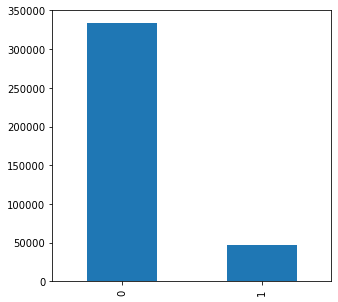

In [10]:
# Checking the Target Variable
train['Response'].value_counts().plot(kind='bar')

In [11]:
# getting the counts of each customer
for cols in train.columns:
    print('------------------------------------')
    print(train[cols].value_counts())

------------------------------------
2049      1
99738     1
19875     1
17826     1
23969     1
         ..
303809    1
305856    1
86655     1
88702     1
2047      1
Name: id, Length: 381109, dtype: int64
------------------------------------
Male      206089
Female    175020
Name: Gender, dtype: int64
------------------------------------
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: Age, Length: 66, dtype: int64
------------------------------------
1    380297
0       812
Name: Driving_License, dtype: int64
------------------------------------
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       

In [12]:
# shape of the dat set

print(train.shape)
print(test.shape)

(381109, 12)
(127037, 11)


In [13]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [15]:
# map them
train['Vehicle_Age'] = train['Vehicle_Age'].replace({'1-2 Year':1, '< 1 Year':0, '> 2 Years':2})
# map them
test['Vehicle_Age'] = test['Vehicle_Age'].replace({'1-2 Year':1, '< 1 Year':0, '> 2 Years':2})

In [18]:
# COnverting to categorical by mapping.

train['Vehicle_Damage'] = train['Vehicle_Damage'].map({'Yes':1, 'No':0})
test['Vehicle_Damage'] = test['Vehicle_Damage'].map({'Yes':1, 'No':0})

In [19]:
# changing Gender to categorical values

train['Gender'] = train['Gender'].astype('category').cat.codes
test['Gender'] = test['Gender'].astype('category').cat.codes

In [20]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.0,1,1,0,30170.0,26.0,88,0
381105,381106,1,30,1,37.0,1,0,0,40016.0,152.0,131,0
381106,381107,1,21,1,30.0,1,0,0,35118.0,160.0,161,0
381107,381108,0,68,1,14.0,0,2,1,44617.0,124.0,74,0


In [21]:
# creating a new data 'df'

df = train.append(test, ignore_index=True, sort=False)

In [549]:
# data columns
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [22]:
# creating a new feature region count by mapping region code to its value counts

df['Region_Count'] = df['Region_Code'].map(df['Region_Code'].value_counts())
#df['Policy_Sales_Channel_Count'] = df['Policy_Sales_Channel'].map(df['Policy_Sales_Channel'].value_counts())

In [25]:
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,26.0_28.0
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,26.0_3.0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,26.0_28.0
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,152.0_11.0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,152.0_41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508141,508142,0,26,1,37.0,1,0,0,30867.0,152.0,56,NaN,7343,152.0_37.0
508142,508143,0,38,1,28.0,0,1,1,28700.0,122.0,165,NaN,141937,122.0_28.0
508143,508144,1,21,1,46.0,1,0,0,29802.0,152.0,74,NaN,26357,152.0_46.0
508144,508145,1,71,1,28.0,1,1,0,62875.0,26.0,265,NaN,141937,26.0_28.0


In [24]:
# creating a new feature

df['policy_region'] = df['Policy_Sales_Channel'].astype(str) + '_' + df['Region_Code'].astype(str)

In [26]:
# converting new feature to categorical variable

df['policy_region'] = df['policy_region'].astype('category').cat.codes

In [27]:
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,1601
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,1603
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,1601
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,862
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508141,508142,0,26,1,37.0,1,0,0,30867.0,152.0,56,NaN,7343,890
508142,508143,0,38,1,28.0,0,1,1,28700.0,122.0,165,NaN,141937,383
508143,508144,1,21,1,46.0,1,0,0,29802.0,152.0,74,NaN,26357,900
508144,508145,1,71,1,28.0,1,1,0,62875.0,26.0,265,NaN,141937,1601


In [34]:
# creating a custom function

def aggregate_functions(df):        
    
    agg_func = {
        'Annual_Premium' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Vintage' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Region_Count' : ['min', 'max', 'std', 'mean', 'median', 'sum']}
    
    agg_df = df.groupby(['Region_Code']).agg(agg_func)
    agg_df.columns = ['_by_region_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Region_Code', how='left')
    
    return agg_df

In [35]:
# new df
df = aggregate_functions(df)

In [36]:
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region,Annual_Premium_by_region_min,Annual_Premium_by_region_max,Annual_Premium_by_region_nunique,Annual_Premium_by_region_size,Annual_Premium_by_region_std,Annual_Premium_by_region_mean,Annual_Premium_by_region_median,Annual_Premium_by_region_sum,Vintage_by_region_min,Vintage_by_region_max,Vintage_by_region_nunique,Vintage_by_region_size,Vintage_by_region_std,Vintage_by_region_mean,Vintage_by_region_median,Vintage_by_region_sum,Region_Count_by_region_min,Region_Count_by_region_max,Region_Count_by_region_std,Region_Count_by_region_mean,Region_Count_by_region_median,Region_Count_by_region_sum
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,1603,2630.0,424578.0,7473,12349,14589.746562,24465.445218,26055.0,3.021238e+08,10,299,290,12349,82.796075,154.864442,154.0,1912421,12349,12349,0.0,12349,12349,152497801
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,862,2630.0,193637.0,7705,12328,14000.397877,27655.183160,29099.5,3.409331e+08,10,299,290,12328,83.740509,154.520360,154.0,1904927,12328,12328,0.0,12328,12328,151979584
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,895,2630.0,339396.0,13801,24400,15174.548982,30948.979918,31623.5,7.551551e+08,10,299,290,24400,83.736493,154.851189,155.0,3778369,24400,24400,0.0,24400,24400,595360000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508141,508142,0,26,1,37.0,1,0,0,30867.0,152.0,56,NaN,7343,890,2630.0,235683.0,4888,7343,14764.025662,28470.157565,31098.0,2.090564e+08,10,299,290,7343,83.631185,153.735122,152.0,1128877,7343,7343,0.0,7343,7343,53919649
508142,508143,0,38,1,28.0,0,1,1,28700.0,122.0,165,NaN,141937,383,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969
508143,508144,1,21,1,46.0,1,0,0,29802.0,152.0,74,NaN,26357,900,2630.0,508073.0,13958,26357,13018.558052,27112.165876,28219.0,7.145954e+08,10,299,290,26357,84.225234,154.642676,154.0,4075917,26357,26357,0.0,26357,26357,694691449
508144,508145,1,71,1,28.0,1,1,0,62875.0,26.0,265,NaN,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969


In [37]:
# creating another custom function to be used to create new features 

def aggregate_functions(df):        
    
    agg_func = {
        'Annual_Premium' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Vintage' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Region_Count' : ['min', 'max', 'std', 'mean', 'median', 'sum']
        }
    
    agg_df = df.groupby(['Policy_Sales_Channel']).agg(agg_func)
    agg_df.columns = ['_by_policy_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Policy_Sales_Channel', how='left')
    
    return agg_df

In [38]:
df = aggregate_functions(df)

In [40]:
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region,Annual_Premium_by_region_min,Annual_Premium_by_region_max,Annual_Premium_by_region_nunique,Annual_Premium_by_region_size,Annual_Premium_by_region_std,Annual_Premium_by_region_mean,Annual_Premium_by_region_median,Annual_Premium_by_region_sum,Vintage_by_region_min,Vintage_by_region_max,Vintage_by_region_nunique,Vintage_by_region_size,Vintage_by_region_std,Vintage_by_region_mean,Vintage_by_region_median,Vintage_by_region_sum,Region_Count_by_region_min,Region_Count_by_region_max,Region_Count_by_region_std,Region_Count_by_region_mean,Region_Count_by_region_median,Region_Count_by_region_sum,Annual_Premium_by_policy_min,Annual_Premium_by_policy_max,Annual_Premium_by_policy_nunique,Annual_Premium_by_policy_size,Annual_Premium_by_policy_std,Annual_Premium_by_policy_mean,Annual_Premium_by_policy_median,Annual_Premium_by_policy_sum,Vintage_by_policy_min,Vintage_by_policy_max,Vintage_by_policy_nunique,Vintage_by_policy_size,Vintage_by_policy_std,Vintage_by_policy_mean,Vintage_by_policy_median,Vintage_by_policy_sum,Region_Count_by_policy_min,Region_Count_by_policy_max,Region_Count_by_policy_std,Region_Count_by_policy_mean,Region_Count_by_policy_median,Region_Count_by_policy_sum
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,1603,2630.0,424578.0,7473,12349,14589.746562,24465.445218,26055.0,3.021238e+08,10,299,290,12349,82.796075,154.864442,154.0,1912421,12349,12349,0.0,12349,12349,152497801,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,862,2630.0,193637.0,7705,12328,14000.397877,27655.183160,29099.5,3.409331e+08,10,299,290,12328,83.740509,154.520360,154.0,1904927,12328,12328,0.0,12328,12328,151979584,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,895,2630.0,339396.0,13801,24400,15174.548982,30948.979918,31623.5,7.551551e+08,10,299,290,24400,83.736493,154.851189,155.0,3778369,24400,24400,0.0,24400,24400,595360000,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508141,508142,0,26,1,37.0,1,0,0,30867.0,152.0,56,NaN,7343,890,2630.0,235683.0,4888,7343,14764.025662,28470.157565,31098.0,2.090564e+08,10,299,290,7343,83.631185,153.735122,152.0,1128877,7343,7343,0.0,7343,7343,53919649,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.87

In [46]:
train = df[df['Response'].isnull()!=True]
test = df[df['Response'].isnull()==True]
test.drop('Response', axis=1, inplace=True)

C:\Users\ITD\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [48]:
test_id = test['id']

In [49]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [50]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region,Annual_Premium_by_region_min,Annual_Premium_by_region_max,Annual_Premium_by_region_nunique,Annual_Premium_by_region_size,Annual_Premium_by_region_std,Annual_Premium_by_region_mean,Annual_Premium_by_region_median,Annual_Premium_by_region_sum,Vintage_by_region_min,Vintage_by_region_max,Vintage_by_region_nunique,Vintage_by_region_size,Vintage_by_region_std,Vintage_by_region_mean,Vintage_by_region_median,Vintage_by_region_sum,Region_Count_by_region_min,Region_Count_by_region_max,Region_Count_by_region_std,Region_Count_by_region_mean,Region_Count_by_region_median,Region_Count_by_region_sum,Annual_Premium_by_policy_min,Annual_Premium_by_policy_max,Annual_Premium_by_policy_nunique,Annual_Premium_by_policy_size,Annual_Premium_by_policy_std,Annual_Premium_by_policy_mean,Annual_Premium_by_policy_median,Annual_Premium_by_policy_sum,Vintage_by_policy_min,Vintage_by_policy_max,Vintage_by_policy_nunique,Vintage_by_policy_size,Vintage_by_policy_std,Vintage_by_policy_mean,Vintage_by_policy_median,Vintage_by_policy_sum,Region_Count_by_policy_min,Region_Count_by_policy_max,Region_Count_by_policy_std,Region_Count_by_policy_mean,Region_Count_by_policy_median,Region_Count_by_policy_sum
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,1603,2630.0,424578.0,7473,12349,14589.746562,24465.445218,26055.0,3.021238e+08,10,299,290,12349,82.796075,154.864442,154.0,1912421,12349,12349,0.0,12349,12349,152497801,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,862,2630.0,193637.0,7705,12328,14000.397877,27655.183160,29099.5,3.409331e+08,10,299,290,12328,83.740509,154.520360,154.0,1904927,12328,12328,0.0,12328,12328,151979584,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,895,2630.0,339396.0,13801,24400,15174.548982,30948.979918,31623.5,7.551551e+08,10,299,290,24400,83.736493,154.851189,155.0,3778369,24400,24400,0.0,24400,24400,595360000,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520


In [51]:
X = train.drop("Response", axis=1)
y = train["Response"]

In [563]:
#categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [52]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostClassifier(eval_metric='AUC', subsample=0.9, l2_leaf_reg=10)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],
          verbose=50, early_stopping_rounds=100)#,verbose=100,cat_features=categorical_features_indices
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

0:	test: 0.8277008	test1: 0.8304453	best: 0.8304453 (0)	total: 709ms	remaining: 11m 48s
50:	test: 0.8535832	test1: 0.8563399	best: 0.8563399 (50)	total: 14.8s	remaining: 4m 35s
100:	test: 0.8561514	test1: 0.8585513	best: 0.8585513 (100)	total: 28.7s	remaining: 4m 15s
150:	test: 0.8577550	test1: 0.8597889	best: 0.8597889 (150)	total: 42s	remaining: 3m 56s
200:	test: 0.8587071	test1: 0.8604849	best: 0.8604849 (200)	total: 55.4s	remaining: 3m 40s
250:	test: 0.8594011	test1: 0.8609153	best: 0.8609153 (250)	total: 1m 8s	remaining: 3m 24s
300:	test: 0.8600506	test1: 0.8612405	best: 0.8612427 (298)	total: 1m 21s	remaining: 3m 9s
350:	test: 0.8606052	test1: 0.8614639	best: 0.8614639 (350)	total: 1m 33s	remaining: 2m 53s
400:	test: 0.8610667	test1: 0.8616579	best: 0.8616579 (400)	total: 1m 46s	remaining: 2m 39s
450:	test: 0.8615435	test1: 0.8618385	best: 0.8618385 (450)	total: 1m 58s	remaining: 2m 24s
500:	test: 0.8620617	test1: 0.8619829	best: 0.8619849 (499)	total: 2m 10s	remaining: 2m 9s
550

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8565182233
bestIteration = 593

Shrink model to first 594 iterations.
err:  0.8565182232527077
0:	test: 0.8276776	test1: 0.8250005	best: 0.8250005 (0)	total: 244ms	remaining: 4m 3s
50:	test: 0.8538959	test1: 0.8505711	best: 0.8505711 (50)	total: 13.6s	remaining: 4m 12s
100:	test: 0.8566747	test1: 0.8536734	best: 0.8536734 (100)	total: 28.8s	remaining: 4m 16s
150:	test: 0.8582621	test1: 0.8550567	best: 0.8550567 (150)	total: 43.1s	remaining: 4m 2s
200:	test: 0.8592903	test1: 0.8556251	best: 0.8556251 (200)	total: 55.5s	remaining: 3m 40s
250:	test: 0.8600333	test1: 0.8560909	best: 0.8560909 (250)	total: 1m 7s	remaining: 3m 21s
300:	test: 0.8606444	test1: 0.8562813	best: 0.8562836 (298)	total: 1m 24s	remaining: 3m 16s
350:	test: 0.8611560	test1: 0.8564095	best: 0.8564178 (337)	total: 1m 36s	remaining: 2m 58s
400:	test: 0.8616971	test1: 0.8564905	best: 0.8565082 (392)	total: 1m 48s	remaining: 2m 42s
450:	test: 0.8621998	t

In [54]:
np.mean(errcb)

0.859110711665512

In [55]:
d = {"id": test_id, 'Response': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
subs = test_predictions[["id", 'Response']].round(4)

In [56]:
subs.to_csv('cat9.csv', index=False)

In [57]:
subs.head()

,id,Response
381109,381110,0.0005
381110,381111,0.3279
381111,381112,0.2940
381112,381113,0.0076
381113,381114,0.0003


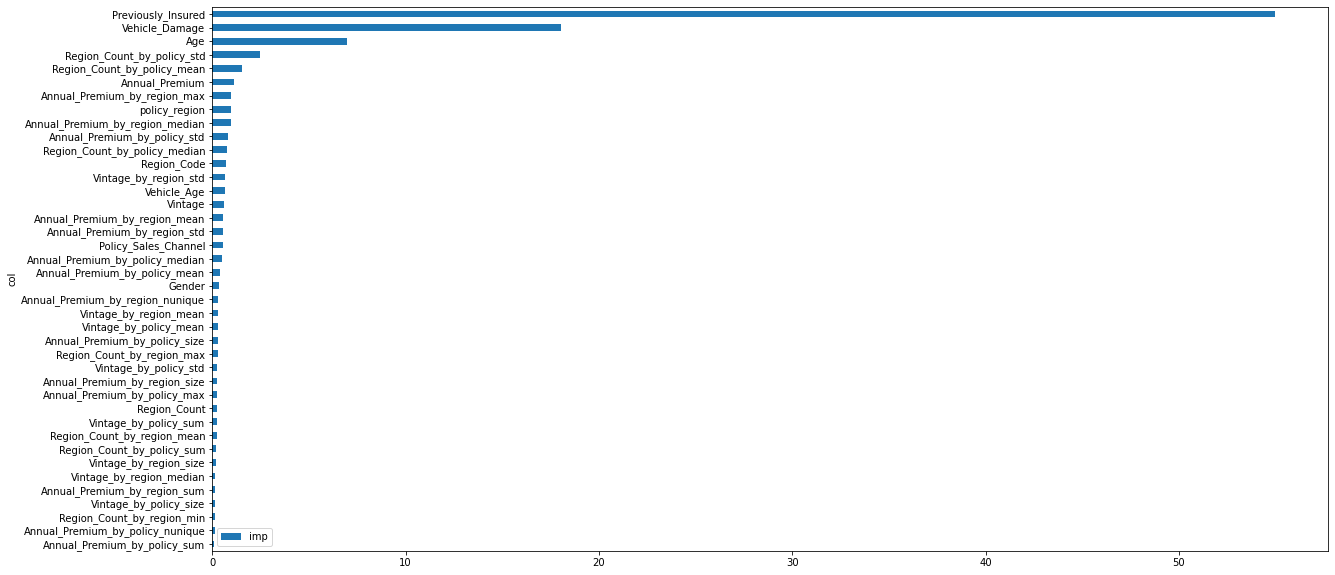

In [59]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-40:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    